using my 'segmentation' virtual environment

brew install graphviz # filas on macos sierra
conda install python-graphviz

In [1]:
%load_ext autoreload
%autoreload 2

import dask_image.imread
import dask_image.ndfilters
import dask_image.ndmeasure
import dask.array as da

import matplotlib.pyplot as plt
%matplotlib inline

import os
from skimage import data, io

In [2]:
path = '/Users/cudmore/box/data/nathan/20200518'

filename_pattern = os.path.join(path, '20200518__A01_G001_*_ch1.tif')

myTile = dask_image.imread.imread(filename_pattern)
print(myTile)

dask.array<concatenate, shape=(48, 64, 512, 512), dtype=uint8, chunksize=(1, 64, 512, 512), chunktype=numpy.ndarray>


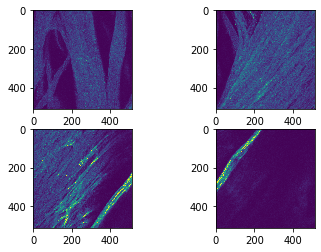

In [3]:
#myTile has 3 color channels as last dimension, just use last dim 0

fig, ax = plt.subplots(nrows=2, ncols=2)
#ax[0,0].imshow(myTile[0][10,:,:,0])
#ax[0,1].imshow(myTile[1][10,:,:,0])
#ax[1,0].imshow(myTile[2][10,:,:,0])
#ax[1,1].imshow(myTile[3][10,:,:,0])
ax[0,0].imshow(myTile[0][10,:,:])
ax[0,1].imshow(myTile[1][10,:,:])
ax[1,0].imshow(myTile[2][10,:,:])
ax[1,1].imshow(myTile[3][10,:,:])
plt.show()

single image

In [4]:
def myGrayscale(rgb):
    result = ((rgb[..., 0] * 0.2125) + 
              (rgb[..., 1] * 0.7154) + 
              (rgb[..., 2] * 0.0721))
    return result

filename = '/Users/cudmore/Desktop/Untitled.png'

astronaut = dask_image.imread.imread(filename)

single_image_result = myGrayscale(astronaut)

print(single_image_result)
print("Original image dimensions: ", astronaut.shape)
print("Processed image dimensions:", single_image_result.shape)

# needs graphviz
#single_image_result.visualize()



dask.array<add, shape=(1, 612, 794), dtype=float64, chunksize=(1, 612, 794), chunktype=numpy.ndarray>
Original image dimensions:  (1, 612, 794, 4)
Processed image dimensions: (1, 612, 794)


multiple images

In [5]:
path = '/Users/cudmore/box/data/nathan/20200518'

filename_pattern = os.path.join(path, '20200518__A01_G001_*_ch1.tif')

myTile = dask_image.imread.imread(filename_pattern)
# for some reason in 'segmentation' environment for Sami, we ended up with an extra dimension
# not the case here?
#myTile = myTile[..., 0]

print('myTile:', myTile.shape)

'''
result = myGrayscale(myTile) # returns dask.array
print(result)
#result.visualize()
'''

myTile: (48, 64, 512, 512)


'\nresult = myGrayscale(myTile) # returns dask.array\nprint(result)\n#result.visualize()\n'

In [6]:
myBlock = da.block(myTile)
myBlock

,Array,Chunk
Bytes,805.31 MB,16.78 MB
Shape,"(48, 64, 512, 512)","(1, 64, 512, 512)"
Count,144 Tasks,48 Chunks
Type,uint8,numpy.ndarray


In [7]:
# if i pass a block here, it takes filter of pixels on edge of image, between different images
#smoothed_image = dask_image.ndfilters.gaussian_filter(myBlock, sigma=[0, 1, 1, 1])
# was this
#smoothed_image = dask_image.ndfilters.median_filter(myBlock, size=(1,2,3,3))

# smooth the first stack
smoothed_image = dask_image.ndfilters.median_filter(myBlock[0], size=(2,3,3))

smoothed_image

dask.array<_trim, shape=(64, 512, 512), dtype=uint8, chunksize=(64, 512, 512), chunktype=numpy.ndarray>

(512, 512)


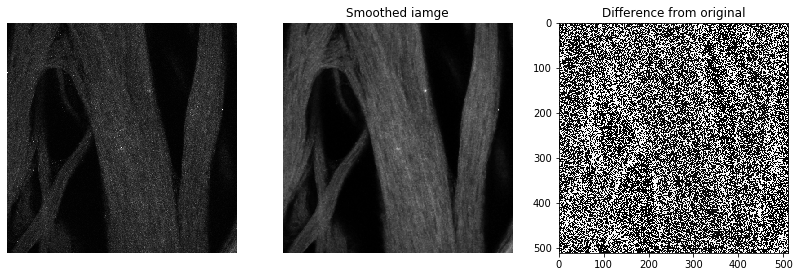

In [8]:
print(myBlock[0,10].shape)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,10))
#axs[0].imshow(myBlock[0,10,...], cmap='gray')
#axs[1].imshow(smoothed_image[0,10,...], cmap='gray')
#axs[2].imshow(smoothed_image[0,10,...] - myBlock[0,10,...], cmap='gray')
axs[0].imshow(myBlock[0,10], cmap='gray')
axs[1].imshow(smoothed_image[10], cmap='gray')
axs[2].imshow(smoothed_image[10] - myBlock[0,10,...], cmap='gray')

# Subplot headings
axs[1].set_title('Smoothed iamge')
axs[2].set_title('Difference from original')

# Don't display axes
axs[0].axis('off')
axs[1].axis('off')

# Display images
plt.show(fig)

starrt a client

requires:
    conda install dask distributed

In [9]:
'''
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client
'''

"\nfrom dask.distributed import Client, progress\nclient = Client(processes=False, threads_per_worker=4,\n                n_workers=1, memory_limit='2GB')\nclient\n"

In [10]:
import scipy
from functools import partial

def last3dims(f):
    # this is just a wrapper because the pycudadecon function
    # expects ndims==3 but our blocks will have ndim==4
    def func(array):
        return f(array[0])[None, ...]
    return func


#myMedianFunc = last3dims(partial(dask_image.ndfilters.median_filter, size=(2,3,3)))
myMedianFunc = last3dims(partial(scipy.ndimage.median_filter, size=(2,3,3)))

myMedian = myTile.map_blocks(myMedianFunc, dtype="uint8")

print(myMedian)
#myMedian[0,...].visualize()

dask.array<func, shape=(48, 64, 512, 512), dtype=uint8, chunksize=(1, 64, 512, 512), chunktype=numpy.ndarray>


Run median filter in parallel (4 cores)

48 images (64, 512, 512) finished in 54 sec, if done in series, takes 216 seconds (4 times faster)

later, 48 images finished in 32.5 sec and series. takes 168 (5 times faster)

In [11]:
import time
startSeconds = time.time()

medianResults = myMedian.compute()

stopSeconds = time.time()
print('finished in', round(stopSeconds-startSeconds,2), 'seconds')

finished in 31.68 seconds


Do it in series

In [12]:
n = len(myMedian)
for idx, i in enumerate(myMedian):
    if idx > 5:
        break
    print(idx, 'of', n)
    startSeconds = time.time()
    i.compute()
    stopSeconds = time.time()
    print('   finished in', round(stopSeconds-startSeconds,2), 'seconds')

0 of 48
   finished in 3.71 seconds
1 of 48
   finished in 3.74 seconds
2 of 48
   finished in 3.74 seconds
3 of 48
   finished in 3.66 seconds
4 of 48
   finished in 3.25 seconds
5 of 48
   finished in 3.37 seconds


now try to run my sliding z on all 48 stacks

In [17]:
import bimpy

startSeconds = time.time()

upDownSlices = 1
mySlidingZ = myTile.map_blocks(bimpy.util.morphology.slidingZ, upDownSlices=upDownSlices, verbose=False, dtype="uint8")
slidingZResults = mySlidingZ.compute()

stopSeconds = time.time()
print('finished in', round(stopSeconds-startSeconds,2), 'seconds')

#slidingZResults

finished in 3.86 seconds


run sliding z in series

In [32]:
n = len(myMedian)
for idx, i in enumerate(myTile):
    if idx > 5:
        break
    print(idx, 'of', n)
    startSeconds = time.time()
    i.compute()
    stopSeconds = time.time()
    print('   finished in', round(stopSeconds-startSeconds,2), 'seconds')

0 of 48
   finished in 0.04 seconds
1 of 48
   finished in 0.04 seconds
2 of 48
   finished in 0.04 seconds
3 of 48
   finished in 0.04 seconds
4 of 48
   finished in 0.04 seconds
5 of 48
   finished in 0.04 seconds


This is freaking complicated, not sure I can do this in a parallel pipeline???

See edt/aicsVasc.py

my aicsVas algorithm is:
 1. load
 2. sliding z
 3. median filter
 4. per slice my_suggest_normalization_param
 5. edge_preserving_smoothing_3d
 6. filament_3d_wrapper
 7. bimpy.util.morphology.labelMask
 8. bimpy.util.morphology.removeSmallLabels
    

In [39]:
# chain all those steps togehter
upDownSlices = 1
currentAnalysis0 = myTile.map_blocks(bimpy.util.morphology.slidingZ, upDownSlices=upDownSlices, verbose=False, dtype="uint8")

print(type(currentAnalysis0[0]))
print(currentAnalysis0[0].shape)

currentAnalysis1 = currentAnalysis0.map_blocks(scipy.ndimage.median_filter, size=(2,3,3), dtype="uint8")


<class 'dask.array.core.Array'>
(64, 512, 512)


In [40]:
# then compute
currentAnalysis1.compute()

RuntimeError: sequence argument must have length equal to input rank